In this sheet I will apply Convolutional Neural Networks for stock prediction of S&P500 index. I will divide data from last 20 years into chunks. Every day contains four values: opening, low, high and closing ones - therefore input data for 30-day chunk has size 30x4. Predicted output is binary: stock will go up or down.

Story: Investor observes stock for 60 days. Then decides whether buy some stocks and sell it after 10 days. Therefore input consist of stock prices from day 1st to 60th, output is:
* 0 if price will go down
* 1 if price will go up

In [1]:
import pandas as pd

df = pd.read_csv('./data/sp500_20Y_with_covid.csv')
df.reindex(index=df.index[::-1])

df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-02-22,1346.089966,1358.109985,1331.880005,1352.170044,1352.170044,980000000
1,2000-02-23,1352.170044,1370.109985,1342.439941,1360.689941,1360.689941,993700000
2,2000-02-24,1360.689941,1364.800049,1329.880005,1353.430054,1353.430054,1215000000
3,2000-02-25,1353.430054,1362.140015,1329.150024,1333.359985,1333.359985,1065200000
4,2000-02-28,1333.359985,1360.819946,1325.069946,1348.050049,1348.050049,1026500000


In [3]:
def percentage_to_label(percentage_value):
    return 0 if percentage_value < 0 else 1

def investor_observes_stocks_for(x_days=60, then_buy_stocks=True, and_sells_them=True, after_y_days=10, dataframe=df):
    assert then_buy_stocks
    assert and_sells_them
    observe_buy_sell_process_length = x_days + after_y_days
    
    observed_chunks = []
    observation_results = []
    
    for first_day_of_observation in range(len(dataframe) - observe_buy_sell_process_length):
        buyout_day = first_day_of_observation + x_days
        sell_day = buyout_day + after_y_days
        
        observed_chunk = dataframe[first_day_of_observation:buyout_day].reset_index()
        observation_result = dataframe.iloc[sell_day]
        
        closing_price_on_buyout_day = dataframe.iloc[buyout_day]['Close']
        opening_price_on_sell_day = dataframe.iloc[sell_day]['Open']
        
        relative_price_change_as_percentage = (opening_price_on_sell_day - closing_price_on_buyout_day) / closing_price_on_buyout_day * 100
        
        observed_chunks += [observed_chunk]
        observation_results += [percentage_to_label(relative_price_change_as_percentage)]
    
    return observed_chunks, observation_results

observed_chunks, observation_results = investor_observes_stocks_for(x_days=60, then_buy_stocks=True, and_sells_them=True, after_y_days=10)

In [4]:
observed_chunks[0].head(10)

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2000-02-22,1346.089966,1358.109985,1331.880005,1352.170044,1352.170044,980000000
1,1,2000-02-23,1352.170044,1370.109985,1342.439941,1360.689941,1360.689941,993700000
2,2,2000-02-24,1360.689941,1364.800049,1329.880005,1353.430054,1353.430054,1215000000
3,3,2000-02-25,1353.430054,1362.140015,1329.150024,1333.359985,1333.359985,1065200000
4,4,2000-02-28,1333.359985,1360.819946,1325.069946,1348.050049,1348.050049,1026500000
5,5,2000-02-29,1348.050049,1369.630005,1348.050049,1366.420044,1366.420044,1204300000
6,6,2000-03-01,1366.420044,1383.459961,1366.420044,1379.189941,1379.189941,1274100000
7,7,2000-03-02,1379.189941,1386.560059,1370.349976,1381.760010,1381.760010,1198600000
8,8,2000-03-03,1381.760010,1410.880005,1381.760010,1409.170044,1409.170044,1150300000
9,9,2000-03-06,1409.170044,1409.739990,1384.750000,1391.280029,1391.280029,1029000000


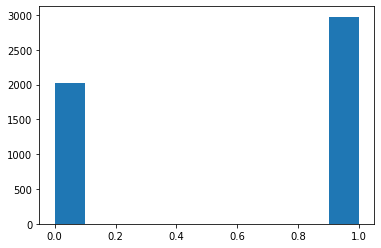

In [6]:
import matplotlib.pyplot as plt

plt.hist(observation_results)
plt.show()

**IMPORTANT NOTE** Selecting test/valiations chunks randomly from the whole set of observation chunks seems to be a big mistake. It causes situation where network actually seen chunks from the future, therefore the more overfitted network, the better results will be. Network should be trained incrementally - with data from time x to x+1 and validated with data from x+1 to x+2. Then learned with data from x to x+2 and validated with data from x+3 to x+3 and so on..

In [14]:
import numpy as np
from keras.utils import to_categorical

def categorical_labels(label_array):
    return to_categorical(list(map(lambda x: x, label_array)))

categorical_labels(observation_results)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [20]:
from keras import models
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.layers.core import Dense, Dropout, Activation, Flatten

model = Sequential()
model.add(Convolution1D(input_shape = (60, 5), filters=16, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(filters=8, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 60, 16)            336       
_________________________________________________________________
batch_normalization_7 (Batch (None, 60, 16)            64        
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 60, 16)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 16)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 60, 8)             520       
_________________________________________________________________
batch_normalization_8 (Batch (None, 60, 8)             32        
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 60, 8)            

In [21]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
X = np.array(list(map(lambda df: df[['Open', 'High', 'Low', 'Close', 'Adj Close']].to_numpy(), observed_chunks)))
Y = np.array(categorical_labels(observation_results))

training_test_split_index = 3 * len(observed_chunks)//4
X_train = X[:training_test_split_index]
Y_train = Y[:training_test_split_index]
X_test = X[training_test_split_index:]
Y_test = Y[training_test_split_index:]

In [23]:
X_train.shape, Y_train.shape

((3752, 60, 5), (3752, 2))

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="model.hdf5", verbose=1, save_best_only=True)

history = model.fit(x=X_train, 
                    y=Y_train, 
                    batch_size=64, 
                    epochs=100, 
                    validation_data=(X_test, Y_test),
                    callbacks = [reduce_lr, checkpointer])

Train on 3752 samples, validate on 1251 samples
Epoch 1/100
3752/3752 [==============================] - 0s 96us/step - loss: 0.6165 - accuracy: 0.6647 - val_loss: 2.2924 - val_accuracy: 0.3965

Epoch 00001: val_loss improved from inf to 2.29240, saving model to model.hdf5
Epoch 2/100
2048/3752 [===============>..............] - ETA: 0s - loss: 0.6163 - accuracy: 0.6709

/Users/mateusz.kuzmik/university/trading-xai/venv/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


3752/3752 [==============================] - 0s 89us/step - loss: 0.6186 - accuracy: 0.6634 - val_loss: 0.7515 - val_accuracy: 0.5963

Epoch 00002: val_loss improved from 2.29240 to 0.75145, saving model to model.hdf5
Epoch 3/100
3752/3752 [==============================] - 0s 86us/step - loss: 0.6113 - accuracy: 0.6644 - val_loss: 1.5514 - val_accuracy: 0.4444

Epoch 00003: val_loss did not improve from 0.75145
Epoch 4/100
3752/3752 [==============================] - 0s 87us/step - loss: 0.6135 - accuracy: 0.6692 - val_loss: 0.8114 - val_accuracy: 0.4764

Epoch 00004: val_loss did not improve from 0.75145
Epoch 5/100
3752/3752 [==============================] - 0s 83us/step - loss: 0.6141 - accuracy: 0.6572 - val_loss: 0.7529 - val_accuracy: 0.6099

Epoch 00005: val_loss did not improve from 0.75145
Epoch 6/100
3752/3752 [==============================] - 0s 85us/step - loss: 0.6120 - accuracy: 0.6676 - val_loss: 2.0197 - val_accuracy: 0.4077

Epoch 00006: val_loss did not improve fro

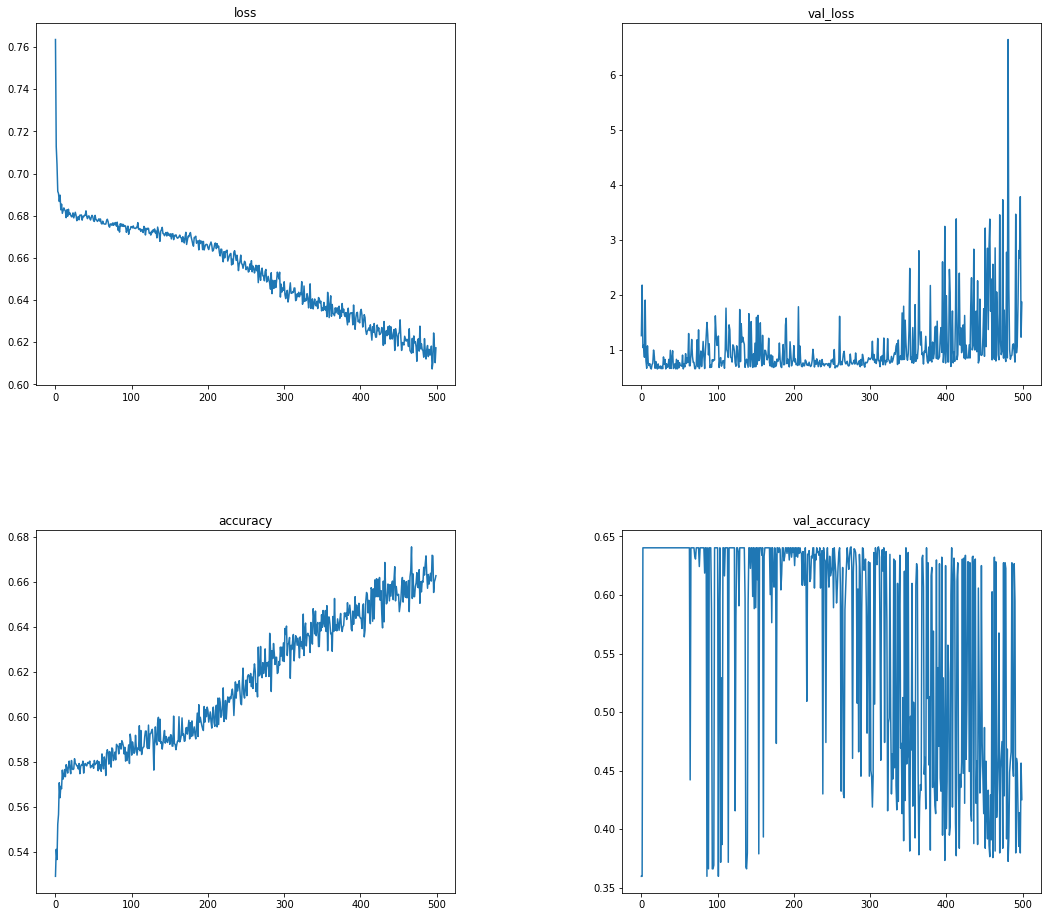

In [26]:
history_dict = history.history
history_dict.keys()

fig = plt.figure(figsize=(18, 16))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.subplot(2, 2, 1)
plt.title('loss')
plt.plot(history_dict['loss'])
plt.subplot(2, 2, 2)
plt.title('val_loss')
plt.plot(history_dict['val_loss'])
plt.subplot(2, 2, 3)
plt.title('accuracy')
plt.plot(history_dict['accuracy'])
plt.subplot(2, 2, 4)
plt.title('val_accuracy')
plt.plot(history_dict['val_accuracy'])

plt.show()

(array([450.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 801.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

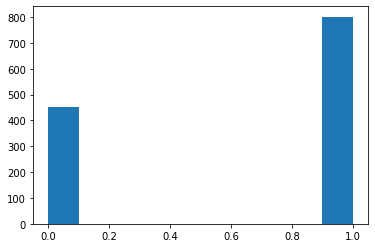

In [32]:
labels = np.argmax(Y_test, axis=1)

filter(lambda x: x[])